# Lab 6B - Custom Dataset and Scheduler

In this lab, we shall learn to implement the following two things:
1. Build a custom dataset with your own data
2. Perform learning rate scheduling

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/My Drive/UCCD3074_Labs/UCCD3074_Lab6"

In [3]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.optim import lr_scheduler

from PIL import Image

Helper functions

In [ ]:
def evaluate(model, testloader):
    # set to evaluation mode
    model.eval()
    
    # running_correct
    running_corrects = 0
    running_count = 0

    for inputs, targets in testloader:
        
        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = model(inputs)
            predicted = outputs > 0.5
            running_corrects += (predicted.view(-1) == targets).sum().double()
            running_count += len(inputs)
            print('.', end='')

    print('\nAccuracy = {:.2f}%'.format(100*running_corrects/running_count))

---
# 1. The Hymenoptera Dataset

The problem we’re going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well. This dataset is a very small subset of imagenet.

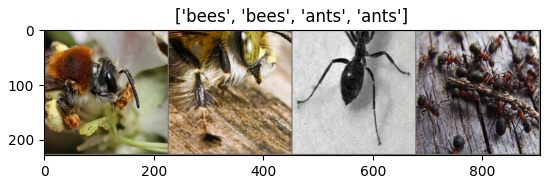

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip
!rm 'hymenoptera_data/train/ants/imageNotFound.gif'

Take a look at the folder `hymenoptera_data`. It has the following directory structure:
```
hymenoptera_data\
   train\
      ants\
      bees\
   val\
      ants\
      bees\
``` 

---
# 2. Implementing a custom dataset

PyTorch provides `torch.utils.data.Dataset` to allow you create your own custom dataset. `Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

* **`__len__`** so that len(dataset) returns the size of the dataset.
* **`__getitem__`** to support the indexing such that dataset[i] can be used to get ith sample

The following code creates a dataset class for the hymenoptera dataset.

In [ ]:
class HymenopteraDataset(Dataset):

    def __init__(self, root, transform=None):
        # ...

    def __len__(self):
        # ...

    def __getitem__(self, idx):
        
        # get the image
        # ...
        
        # perform transformation
        # ...
        
        # get the label
        # ...
        
        return image, label

* **`__init__`**: Get the filenames of all training samples (`self.data`) and their corresponding labels (`self.labels`)
    * Line 10: 
    <br> If `transform` is passed by the user, all images would be transformed using this pipeline when they are read in `__getitem__` later. 
    * Line 11: 
    <br> There are 2 classes in the dataset (0: ants, 1: bees)
    * Line 14-21: 
    <br> For each of the class (line 14), get the names of all the files in their class directories (line 19) and update `self.data` (line 20) and `self.labels` (line 21).

* **`__getitem__`**: Read the image and label. Transform the image if required. Return the transformed image and label.

While it is possible to load all images in the `__init__`, we have choosen to read the images only when requested by the user in `__getitem__`. This is more memory efficient because all the images are not stored in the memory at once but read as required. This is the normal setup when the dataset is huge.


#### Instantiating `HymenopteraDataset`

Let's instantiate the HymenopteraDataset and look into one of its sample.

In [ ]:
trainset = HymenopteraDataset('./hymenoptera_data/train', transform=None)

print('Number of samples in dataset:', len(trainset))
print('Number of classes:', trainset.classes)

* `Line 1`: When creating `trainset`, the function `__init__` will be called to populate `trainset.data` and `trainset.labels`.

Next, we look into the first sample in the dataset. Since we did not transform the image, we can still display the image without undoing the transformation.

In [ ]:
image, label = trainset[1]
display(image)
print("Class =", trainset.classes[label])

#### Transformation and Data Loader

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# trainset = HymenopteraDataset("./hymenoptera_data/train", ...)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

---

# 3 Customizing EfficientNet for Binary Classification

Now, customize EfficientNet B0 (`torchvision.models.efficientnet_b0`) to build a classifier to differentiate between *ants* vs *bees*. We shall build our model using pre-trained model from ImageNet to build our model.  

In [ ]:
net = models.efficientnet_b0(weights='IMAGENET1K_V1')
in_c = net.classifier[1].in_features 
net.classifier[1] = nn.Sequential(
    nn.Linear(in_c, 1),
    nn.Sigmoid()
)

---
# 4. Train the Model

Now we are ready to train the model. In the following, we define the transformation, set up our optimizer, and then define the training function before training the model. Define the transformation function to augment the dataset.

Set up the optimizer with momentum. Set the learning rate `lr` to 0.01 and `momentum` to 0.9.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Set up the scheduler. In the following, we are going to use the **step decay schedule**. We shall drop the learning rate by a factor of 0.1 every 10 epochs.

In [ ]:
# scheduler = ...

Train the model. We pass both the dataloader, optimizer and scheduler into the function. In order to reduce the learning rate according to the schedule, you must **`scheduler.step`** at the end of every epoch

Now we are ready to train our model. We should expect training loss of about 0.2.

In [ ]:
def train(net, trainloader, optimizer, scheduler, num_epochs):
    
    history = []
    
    # transfer model to GPU
    if torch.cuda.is_available():
        net = net.cuda()
    
    # set to training mode
    net.train()

    # train the network
    for e in range(num_epochs):    

        running_loss = 0.0
        running_count = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            labels = labels.reshape(-1, 1).float()
            
            # Clear all the gradient to 0
            optimizer.zero_grad()

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = net(inputs)
        
            # compute loss 
            loss = F.binary_cross_entropy(outs, labels)

            # backpropagation to get dw
            loss.backward()

            # update the parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

        # compute the averaged loss in each epoch
        train_loss = running_loss / running_count
        running_loss = 0. 
        running_count = 0.
        print(f'Epoch {e+1:2d}/{num_epochs:d} : train_loss = {train_loss:.4f}')       

        # Update the scheduler's counter at the end of each epoch
        # ...

    return 

In [ ]:
train (net, trainloader, optimizer, scheduler, num_epochs=50)

# Evaluate the model

The following code then evaluates the model. The expected accuracy is around 86%.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = HymenopteraDataset("./hymenoptera_data/val", transform=val_transform)
testloader = DataLoader(testset, batch_size=4, shuffle=True, num_workers=0)

In [ ]:
evaluate(net, testloader)

<center> --- End of Lab --- </center>